In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [5]:
data_dir = 'data/'
train = pd.read_csv(data_dir + 'train_with_aqi.csv')
test = pd.read_csv(data_dir + 'test_with_aqi.csv')
feature_cols = [
    "temp", 
    "humidity", 
    "precip",
    "overall_AQI"
]

class WeatherDataset(Dataset):
    def __init__(self, df, features, target, window_size=10, step_size=1, steps_ahead=1):
        df = df.fillna(0)
        self.date = df['datetime'].values
        self.features = df[features].values
        self.ori_features = self.features
        self.window_size = window_size
        self.step_size = step_size
        self.steps_ahead = steps_ahead
        self.target = df[target].values
        self.normalize()
        self.construct_sequences(window_size, step_size, steps_ahead)
    
    
    def normalize(self):
        self.feat_mean = np.mean(self.features, axis=0)
        self.feat_std = np.std(self.features, axis=0)
        self.target_mean = np.mean(self.target, axis=0)
        self.target_std = np.std(self.target, axis=0)
        self.features = (self.features - self.feat_mean) / self.feat_std
        self.target = (self.target - self.target_mean) / self.target_std
        
    
        
        
    def construct_sequences(self, window_size, step_size, steps_ahead):
        features = []
        target = []
        for i in range(0, len(self.features) - window_size - steps_ahead + 1, step_size):
            features.append(self.features[i:i+window_size])
            target.append(self.target[i+window_size:i+window_size+steps_ahead])
        self.features = np.array(features)
        self.target = np.array(target)
        

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx], self.date[idx+self.window_size] 
    
    
def collate_fn(batch):
    features = []
    target = []
    target_date = []
    for f, t, d in batch:
        features.append(f)
        target.append(t)
        target_date.append(d)
    return torch.tensor(features, dtype=torch.float32), torch.tensor(target, dtype=torch.float32), target_date

In [6]:
train_data = WeatherDataset(train, feature_cols, feature_cols, window_size=3)
test_data = WeatherDataset(test, feature_cols, feature_cols, window_size=3)

In [8]:

class WeatherModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=32, output_size=4, num_layers=3):
        super(WeatherModel, self).__init__()
        self.RNN_Encoder = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
        
        
    def forward(self, x):
        # print(x.shape)
        out, hs = self.RNN_Encoder(x)
        out = self.fc(out) # B, L, D
        return out
    
    
    

# Test
model = WeatherModel()
features, target,_ = train_data[0] # t0, t1, t2
features = torch.tensor(features, dtype=torch.float32).unsqueeze(0)
target = torch.tensor(target, dtype=torch.float32).unsqueeze(0) # t3
output = model(features) # t1, t2, t3
target = torch.cat([features[:, 1:], target], dim=1)
print(output.shape, target.shape)

torch.Size([1, 3, 4]) torch.Size([1, 3, 4])


In [306]:
def train(model, criterion, optimizer, train_loader, epochs=10, device='cpu'):
    best_loss = np.inf
    best_model = None
    for epoch in range(epochs):
        model.train()
        loss_history = []
        for i, (features, target, _) in enumerate(train_loader):
            features = features.to(device, dtype=torch.float32)
            target = target.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            output = model(features)
            target_seq = torch.cat([features[:, 1:], target], dim=1)
            
            loss = criterion(output, target_seq)
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())
            
        epoch_loss = np.mean(loss_history)
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            # save the best model
            best_model = model.state_dict()
            torch.save(best_model, 'best_model.pth')
        print(f'Epoch {epoch} Loss: {epoch_loss}')
    return best_model
        
        
def test(model, criterion, test_loader, device='cpu'):
    model.eval()
    predictions = []
    with torch.no_grad():
        for idx, (features, target, date) in enumerate(test_loader):
            features = features.to(device,dtype=torch.float32)
            target = target.to(device, dtype=torch.float32)
            output = model(features)[:, -1, :]
            loss = criterion(output, target)       
            print(f'Test Loss: {loss.item()}')
            predictions.append({"date": date, "prediction": output.cpu().numpy()})
    return predictions

In [301]:
model = WeatherModel(input_size=4, hidden_size=16, output_size=4,num_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


WeatherModel(
  (RNN_Encoder): GRU(4, 16, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [302]:
train_data[0]

(array([[-1.48807225, -1.35864164, -0.39762618, -1.69823911],
        [-1.0422029 , -1.28220408, -0.39762618,  1.34220701],
        [-1.42437663, -0.09742195,  1.39041992,  1.09568435]]),
 array([[-0.67740071,  1.96639208,  2.05738949, -0.71214848]]),
 '2015-01-04')

In [304]:
train(model, criterion, optimizer, train_loader, epochs=10, device=device)

Epoch 0 Loss: 0.7612807259024739
Epoch 1 Loss: 0.6291660520307994
Epoch 2 Loss: 0.610601695674878
Epoch 3 Loss: 0.6055344832008743
Epoch 4 Loss: 0.6016980144214369
Epoch 5 Loss: 0.5986689713193682
Epoch 6 Loss: 0.5965923613750168
Epoch 7 Loss: 0.5946717615737471
Epoch 8 Loss: 0.5940524909018492
Epoch 9 Loss: 0.5923082028221334


OrderedDict([('RNN_Encoder.weight_ih_l0',
              tensor([[ 5.0016e-02, -3.8381e-01,  9.3140e-02, -6.1494e-02],
                      [-2.1602e-01,  2.2278e-01,  8.7334e-01,  3.1804e-01],
                      [ 4.7012e-01,  2.0495e-01, -1.7855e-01, -2.5002e-01],
                      [-8.5344e-03, -2.2725e-01, -4.3456e-01, -2.8511e-01],
                      [-1.5756e-01, -2.9472e-01,  3.7530e-02, -1.3696e-01],
                      [ 3.6056e-01, -4.3481e-02, -3.8433e-01,  1.4818e-01],
                      [ 2.4548e-01, -3.3031e-01,  4.2965e-01,  3.8397e-01],
                      [-6.0114e-01, -8.3341e-02,  3.7795e-01,  3.1372e-02],
                      [ 2.8444e-01, -3.1128e-02, -1.6326e-01,  1.5141e-01],
                      [-1.0849e-01,  8.6562e-02,  2.7968e-01,  1.7393e-01],
                      [-2.3920e-01, -7.8703e-01, -3.0496e-01, -1.3066e-01],
                      [ 2.7799e-01,  3.8128e-01,  2.1410e-01,  6.0888e-02],
                      [ 1.1124e-01,  6.7865e-0

In [219]:
test_data.target

array([[[-1.04433204, -0.50070938, -0.38811281]],

       [[-1.64037763, -1.20307493, -0.38811281]],

       [[-1.2262828 ,  0.15736285, -0.2272735 ]],

       ...,

       [[-0.07183661,  0.82176269,  1.26443226]],

       [[-0.60514056,  0.04979335, -0.38811281]],

       [[-0.54239892,  1.18876451,  1.57034231]]])

/var/folders/94/1xljz3b92jj_7rvffd7h177c0000gn/T/ipykernel_15993/2521813.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth

Test Loss: 0.18029183149337769
Test Loss: 0.427556574344635
Test Loss: 0.20664170384407043
Test Loss: 2.326587200164795
Test Loss: 0.31482329964637756
Test Loss: 0.8872901201248169
Test Loss: 9.106267929077148
Test Loss: 0.07125507295131683
Test Loss: 0.4791615903377533
Test Loss: 4.135028839111328
Test Loss: 0.2848321497440338
Test Loss: 0.31372392177581787
Test Loss: 1.9148893356323242
Test Loss: 0.4419216215610504
Test Loss: 0.6698640584945679
Test Loss: 0.07292774319648743
Test Loss: 0.26246532797813416
Test Loss: 0.28955769538879395
Test Loss: 0.4295656085014343
Test Loss: 0.19442802667617798
Test Loss: 1.298442006111145
Test Loss: 0.8205127716064453
Test Loss: 1.9742469787597656
Test Loss: 0.6531465649604797
Test Loss: 0.622611939907074
Test Loss: 0.16046607494354248
Test Loss: 0.2422705888748169
Test Loss: 0.2545272409915924
Test Loss: 0.13343414664268494
Test Loss: 0.45889467000961304
Test Loss: 0.44152453541755676
Test Loss: 0.2167317420244217
Test Loss: 0.31782644987106323
Te

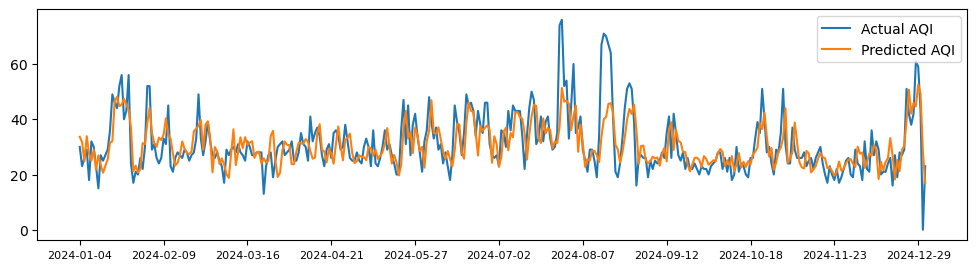

In [319]:
# Transforem the data back to the original scale
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
result = test(model, criterion, test_loader, device=device)

dates = [p['date'][0] for p in result]
result = [p['prediction'] for p in result]
result = np.concatenate(result, axis=0)


prediction = result * test_data.target_std + test_data.target_mean
target  = test_data.target * test_data.target_std + test_data.target_mean
target = target.squeeze()
result = result.squeeze()


plt.figure(figsize=(12, 3))
plt.plot(target[:, 3], label='Actual AQI')
plt.plot(prediction[:, 3], label='Predicted AQI')
plt.legend(loc='upper right')


plt.xticks(range(0, len(dates), len(dates) // 10), dates[::len(dates) // 10])
plt.tick_params(axis='x', labelsize=8)



plt.savefig('result.pdf')
plt.show()
# ax, fig = 
# fig.plot(prediction[:, -1], label='Predicted AQI')
# fig.plot(target[:, -1], label='Actual AQI')
# fig.legend(loc='upper right')


# axes, fig = plt.subplots(4, 1, figsize=(16, 6))
# fig[0].plot(prediction[:, 0], label='Predicted Temperature')
# fig[0].plot(target[:, 0], label='Actual Temperature')
# fig[0].legend(loc='upper right')
# # legend location

# fig[1].plot(prediction[:, 1], label='Predicted Humidity')
# fig[1].plot(target[:, 1], label='Actual Humidity')
# fig[1].legend(loc='upper right')
# fig[2].plot(prediction[:, 2], label='Predicted Precip')
# fig[2].plot(target[:, 2], label='Actual Precip')
# fig[2].legend(loc='upper right')

# fig[3].plot(prediction[:, 3], label='Predicted AQI')
# fig[3].plot(target[:, 3], label='Actual AQI')
# fig[3].legend(loc='upper right')


